In [1]:
%%time
import bayes3d as b
import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm

CPU times: user 4.41 s, sys: 1.86 s, total: 6.27 s
Wall time: 3.63 s


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.001, far=6.0
)

cube = b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.1]))
renderer = b.Renderer(intrinsics)
renderer.add_mesh(cube)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 512)


In [4]:
contact_plane = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 2.0, 0.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
))
contact_poses_jit = jax.jit(
    jax.vmap(
        b.scene_graph.relative_pose_from_edge,
        in_axes=(0, None, None),
    )
)

In [5]:
poses = contact_plane @ contact_poses_jit(
        jnp.array([
        [0.0, 0.0, 1.0],
        [0.2, 0.3, 0.0],
        [0.3, 0.0, 1.0],
        [0.2, 0.1, 0.4],
    ]),
    0,
    renderer.model_box_dims[0]
)

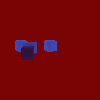

In [6]:
observed_point_cloud_image = renderer.render_multiobject(poses, [0 for _ in range(len(poses))])[:,:,:3]
b.clear()
b.show_cloud("1", observed_point_cloud_image[:,:,:3].reshape(-1,3))
b.get_depth_image(observed_point_cloud_image[:,:,2])


In [7]:
grid_params = [
    (1.0, jnp.pi, (11,11,11)), (0.6, jnp.pi/3, (11,11,11)), (0.4, jnp.pi/5, (11,11,1)),
    (0.0, jnp.pi/2, (1,1,11*11)), (0.2, jnp.pi/5, (11,11,11)), 
    (0.1, 0.0, (16,16,1)),
    (0.0, jnp.pi/10, (1,1,11*11)),
    (0.05, 0.0, (16,16,1)),
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [8]:
# trace = Trace(
#     plane_pose[None,...], [21],
#     VARIANCE, 0.01,
#     observed_point_cloud_image
# )
VARIANCE_GRID = jnp.array([0.00005])
OUTLIER_GRID = jnp.array([ 0.001])

trace = b.Trace(
    jnp.zeros((0,4,4)), [],
    VARIANCE_GRID[0], OUTLIER_GRID[0], 0.1,
    observed_point_cloud_image
)
b.viz_trace_meshcat(trace, renderer)

In [9]:
for _ in range(5):
    _all_traces = []
    all_traces = []
    for obj_id in tqdm(range(len(renderer.meshes))):
        contact_param = jnp.zeros(3)
        p = None
        traces = None
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param

            potential_new_object_poses = contact_plane @ contact_poses_jit(
                contact_param_grid,
                3,
                renderer.model_box_dims[obj_id],
            )

            potential_poses = jnp.concatenate(
                [
                    jnp.tile(trace.poses[:,None,...], (1,potential_new_object_poses.shape[0],1,1)),
                    potential_new_object_poses[None,...]
                ]
            )

            traces = b.Traces(
                potential_poses, trace.ids + [obj_id], VARIANCE_GRID, OUTLIER_GRID,
                trace.outlier_volume, trace.observation
            )
            p = b.score_traces(traces, renderer)      

            ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
            contact_param = contact_param_grid[ii]

        best_trace = b.Trace(
            traces.all_poses[:,ii], traces.ids, traces.all_variances[jj],
            traces.all_outlier_prob[kk], traces.outlier_volume,
            traces.observation
        )

        all_traces.append(
            best_trace
        )


    scores = jnp.array([b.score_trace(t, renderer) for t in all_traces])
    normalized_scores = b.utils.normalize_log_scores(scores)
    print(["{:0.3f}".format(n) for n in normalized_scores])
    order = jnp.argsort(-scores)
    print(order)
    trace = all_traces[jnp.argmax(scores)]
    print(trace.ids)
    b.viz_trace_meshcat(trace, renderer)


100%|████████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


['1.000']
[0]
[0]


100%|████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]


['1.000']
[0]
[0, 0]


100%|████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


['1.000']
[0]
[0, 0, 0]


100%|████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


['1.000']
[0]
[0, 0, 0, 0]


100%|████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]

['1.000']
[0]
[0, 0, 0, 0, 0]
